# Carry Tables

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import functions
import math
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

## Display Carry Tables

In [3]:
d=4 #modulus

basic_table=1*(np.add.outer(np.arange(d),np.arange(d))>=d)
alt_table=np.array([[0,0,0,0],
                    [0,3,3,3],
                    [0,3,3,0],
                    [0,3,0,0]])

### Basic Table, depth $\in [1:3]$

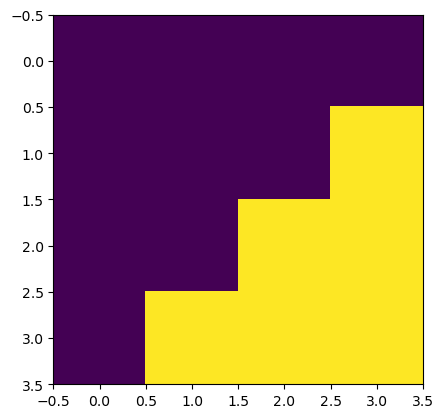

In [4]:
plt.imshow(functions.construct_product_table(basic_table,1))

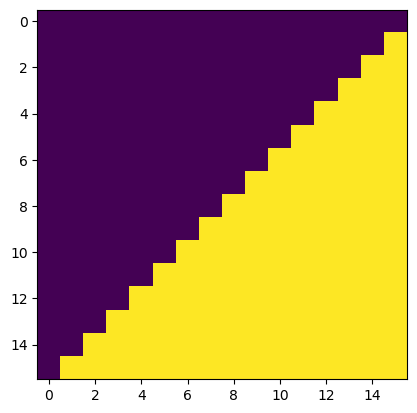

In [5]:
plt.imshow(functions.construct_product_table(basic_table,2))

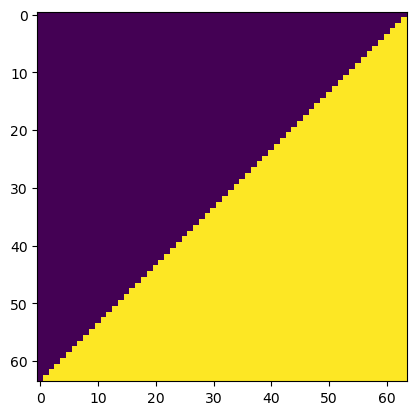

In [6]:
plt.imshow(functions.construct_product_table(basic_table,3))

### Alternative Table, depth $\in [1:4]$

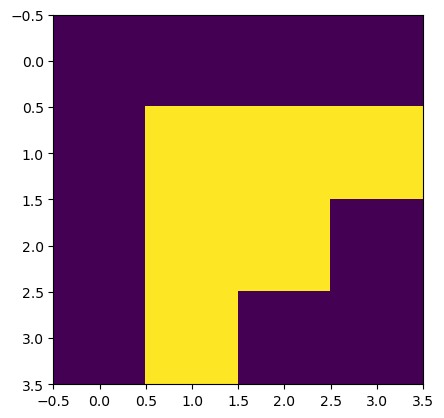

In [7]:
plt.imshow(functions.construct_product_table(alt_table,1))

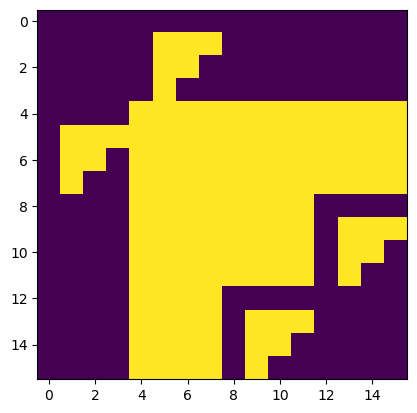

In [8]:
plt.imshow(functions.construct_product_table(alt_table,2))

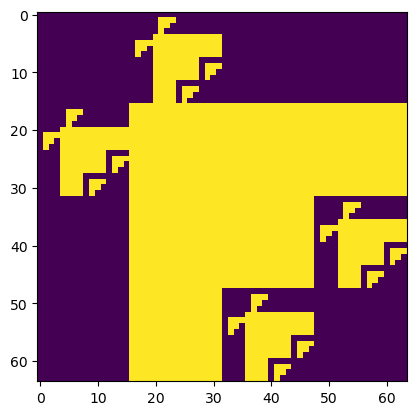

In [9]:
plt.imshow(functions.construct_product_table(alt_table,3))

## Compare Carry Tables

### Find alternative cocycles

In [12]:
tables3 = functions.construct_tables(3)

  0%|          | 0/9 [00:00<?, ?it/s]

In [13]:
tables4 = functions.construct_tables(4)

  0%|          | 0/64 [00:00<?, ?it/s]

In [14]:
tables5 = functions.construct_tables(5, sample=True, frac=0.5)

  0%|          | 0/625 [00:00<?, ?it/s]

In [21]:
tables6 = functions.construct_tables(6, sample=True, frac=0.5)

  0%|          | 0/7776 [00:00<?, ?it/s]

In [16]:
tables7 = functions.construct_tables(7, sample=True, frac=0.1)

  0%|          | 0/117649 [00:00<?, ?it/s]

In [22]:
tables8 = functions.construct_tables(8, sample=True, n=5)

  0%|          | 0/2097152 [00:00<?, ?it/s]

In [155]:
all_tables = {
    3: tables3,
    4: tables4,
    5: tables5,
    6: tables6,
    7: tables7,
    8: tables8,
    # 9: tables9,
    # 10: tables10
}

In [156]:
with open('carry_tables/all_tables.pickle', 'wb') as f:
    pickle.dump(all_tables, f)

### Plot their carry tables

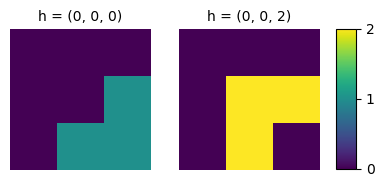

In [144]:
functions.show_tables(tables3, 3, depth=1)

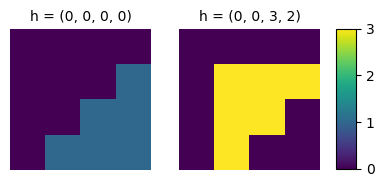

In [145]:
functions.show_tables(tables4, 4, depth=1)

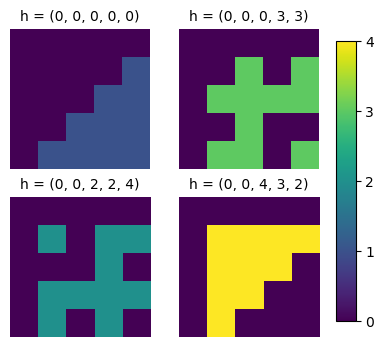

In [146]:
functions.show_tables(tables5, 5, depth=1)

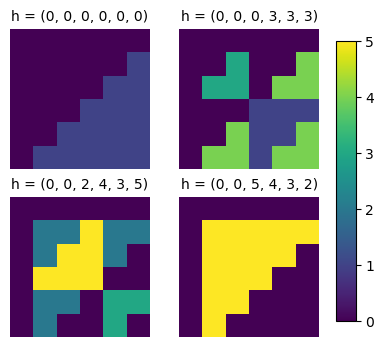

In [147]:
functions.show_tables(tables6, 6, depth=1)

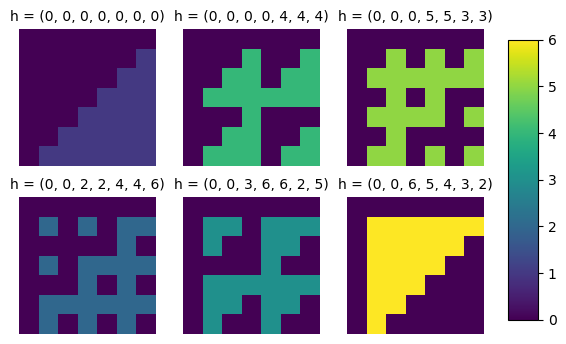

In [148]:
functions.show_tables(tables7, 7, depth=1)

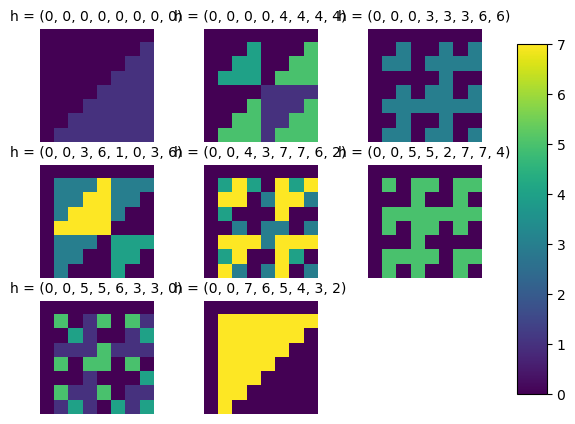

In [169]:
show_tables(tables8, 8, depth=1)

### Check how the recursive tables compare in terms of isomorphisms of groups

In [ ]:
h = '(0, 0, 0, 0, 0, 0)'
zero = RecursiveGrpElt((0, 0), tables6[h])
one = RecursiveGrpElt((0, 1), tables6[h])
cycle = [e.vals]
for t in range(g.d**len(g.vals) - 1):
    e += g
    cycle.append(e.vals)

### Count number of zeros in each table

In [166]:
all_tables[4]['(0, 0, 0, 0)']

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 1],
       [0, 1, 1, 1]])

In [167]:
for b in range(3, 9):
    print('b =', b)
    print()
    for h in all_tables[b].keys():
        print('h =', h)
        for depth in range(1, 4):
            table = functions.construct_product_table(all_tables[b][h], depth=depth)
            print('# of zeros =', table.size - np.count_nonzero(table), '(depth =', str(depth)+')')
        print()
    print()

b = 3

h = (0, 0, 0)
# of zeros = 6 (depth = 1)
# of zeros = 45 (depth = 2)
# of zeros = 378 (depth = 3)

h = (0, 0, 2)
# of zeros = 6 (depth = 1)
# of zeros = 45 (depth = 2)
# of zeros = 378 (depth = 3)


b = 4

h = (0, 0, 0, 0)
# of zeros = 10 (depth = 1)
# of zeros = 136 (depth = 2)
# of zeros = 2080 (depth = 3)

h = (0, 0, 3, 2)
# of zeros = 10 (depth = 1)
# of zeros = 136 (depth = 2)
# of zeros = 2080 (depth = 3)


b = 5

h = (0, 0, 0, 0, 0)
# of zeros = 15 (depth = 1)
# of zeros = 325 (depth = 2)
# of zeros = 7875 (depth = 3)

h = (0, 0, 0, 3, 3)
# of zeros = 15 (depth = 1)
# of zeros = 325 (depth = 2)
# of zeros = 7875 (depth = 3)

h = (0, 0, 2, 2, 4)
# of zeros = 15 (depth = 1)
# of zeros = 325 (depth = 2)
# of zeros = 7875 (depth = 3)

h = (0, 0, 4, 3, 2)
# of zeros = 15 (depth = 1)
# of zeros = 325 (depth = 2)
# of zeros = 7875 (depth = 3)


b = 6

h = (0, 0, 0, 0, 0, 0)
# of zeros = 21 (depth = 1)
# of zeros = 666 (depth = 2)
# of zeros = 23436 (depth = 3)

h = (0, 0, 0, 3, 

### Count number of unique nubers in each table

In [170]:
for b in range(3, 9):
    print('b =', b)
    print()
    for h in all_tables[b].keys():
        print('h =', h)
        for depth in range(1, 4):
            table = functions.construct_product_table(all_tables[b][h], depth=depth)
            print("unique #'s =", len(np.unique(table)), '(depth =', str(depth)+')')
        print()
    print()

b = 3

h = (0, 0, 0)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)

h = (0, 0, 2)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)


b = 4

h = (0, 0, 0, 0)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)

h = (0, 0, 3, 2)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)


b = 5

h = (0, 0, 0, 0, 0)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)

h = (0, 0, 0, 3, 3)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)

h = (0, 0, 2, 2, 4)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)

h = (0, 0, 4, 3, 2)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)


b = 6

h = (0, 0, 0, 0, 0, 0)
unique #'s = 2 (depth = 1)
unique #'s = 2 (depth = 2)
unique #'s = 2 (depth = 3)

h = (0, 0, 0, 3, 3, 3)
unique #'s = 4 (depth = 1)
unique #'s = 5 (